# Set Up

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CBFV import composition
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Multiply, Concatenate, Activation, Add, LeakyReLU, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from datetime import datetime
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import shap

/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

## Seed and Paths

In [3]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'Data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'Models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

# Data

## Collection

In [4]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_train7.csv"))
df_val = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_val7.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_test7.csv"))

## Preprocessing

In [5]:
df_train = df_train.drop_duplicates()
df_val = df_val.drop_duplicates()
df_test = df_test.drop_duplicates()

In [6]:
drop_columns = ['composition', 'material_id', 'structure',
                'total_magnetization', 'total_magnetization_normalized_vol']
df_train.drop(
    columns=[col for col in drop_columns if col in df_train.columns], inplace=True)
df_val.drop(
    columns=[col for col in drop_columns if col in df_val.columns], inplace=True)
df_test.drop(
    columns=[col for col in drop_columns if col in df_test.columns], inplace=True)


df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5197, 1594)
df_val DataFrame shape: (1504, 1594)
df_test DataFrame shape: (747, 1594)


In [7]:
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}

df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(
    df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(
    df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(
    df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns = X_train_unscaled.columns.values.tolist()

Processing Input Data: 100%|██████████| 5197/5197 [00:00<00:00, 50145.15it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5197/5197 [00:00<00:00, 37659.42it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1504/1504 [00:00<00:00, 55146.24it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1504/1504 [00:00<00:00, 37064.30it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 747/747 [00:00<00:00, 53250.37it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 747/747 [00:00<00:00, 36666.41it/s]


	Creating Pandas Objects...


In [8]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# X_test = normalize(X_test)

In [9]:
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(6701, 1746)


In [10]:
enc = OrdinalEncoder()

df_train_new = pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula", "number"]])
df_train_new[["formula", "number"]] = enc.transform(
    df_train_new[["formula", "number"]])

# Models

### Non-Reduced

In [11]:
def build_advanced_regression_model(input_shape, dropout_rate=0.5, weight_decay=1e-4):
    inputs = Input(shape=(input_shape,))

    x = Dense(512, activation=None,
              kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    skip1 = Dense(256, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip1 = BatchNormalization()(skip1)
    skip1 = Activation('relu')(skip1)

    x = Dense(256, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Add()([x, skip1])

    x = Dense(128, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    skip2 = Dense(128, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip2 = BatchNormalization()(skip2)
    skip2 = Activation('relu')(skip2)
    x = Add()([x, skip2])

    x = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)

    output = Dense(1, activation='linear')(x)

    model = Model(inputs, output)
    model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss='mean_squared_error',
        metrics=['root_mean_squared_error']
    )

    return model

In [12]:
input_shape = X_train.shape[1]

model = build_advanced_regression_model(input_shape)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1746)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    894,464 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    447,232 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    223,616 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,742,977 (6.65 MB)

 Trainable params: 1,740,417 (6.64 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 66.2215 - root_mean_squared_error: 8.0952 - val_loss: 39.6703 - val_root_mean_squared_error: 6.2807
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 45.7787 - root_mean_squared_error: 6.7244 - val_loss: 29.1718 - val_root_mean_squared_error: 5.3793
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 36.7849 - root_mean_squared_error: 6.0206 - val_loss: 25.8639 - val_root_mean_squared_error: 5.0614
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 33.0289 - root_mean_squared_error: 5.7189 - val_loss: 23.4274 - val_root_mean_squared_error: 4.8135
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 30.8214 - root_mean_squared_error: 5.5064 - val_loss: 21.3624 - val_root_mean_squared_error: 4.5931
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 26.7022 - root_mean_squared_error: 5.1346 - val_loss: 21.3778 - val_root_mean_squared_error: 4.5936
Epoch 7/100
163/163 ━━━━━━━━

In [13]:
test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.6781 - root_mean_squared_error: 3.5094
Test Loss: 17.0687, Test RMSE: 4.0328


#### Evaluation

In [14]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared: 0.8011
Root Mean Squared Error: 4.0328


In [15]:
y_val_pred = model.predict(X_val)

r2 = r2_score(y_val, y_val_pred)
print(f"R-squared: {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared: 0.8326
Root Mean Squared Error: 3.6279


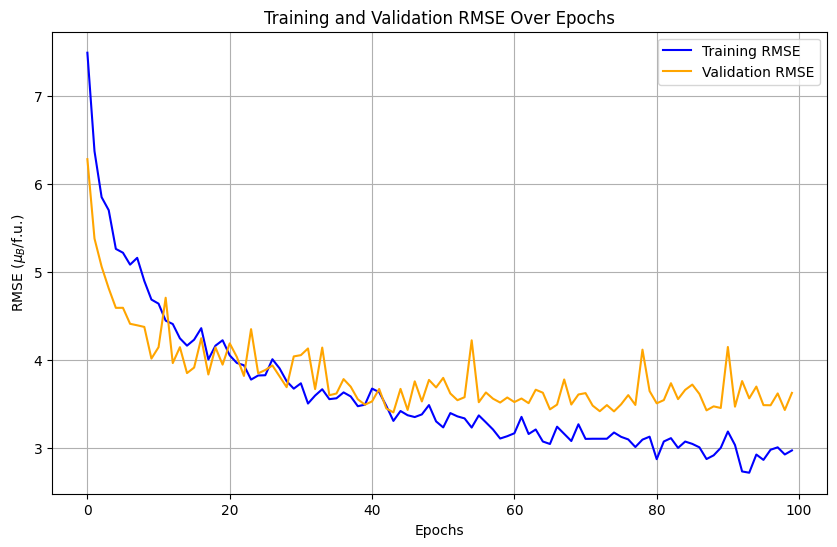

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'],
         label='Training RMSE', color='blue')
plt.plot(history.history['val_root_mean_squared_error'],
         label='Validation RMSE', color='orange')

plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE ($\u03bc_B$/f.u.)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
y_test_flat = np.array(y_test).flatten()
y_pred_flat = np.array(y_pred).flatten()

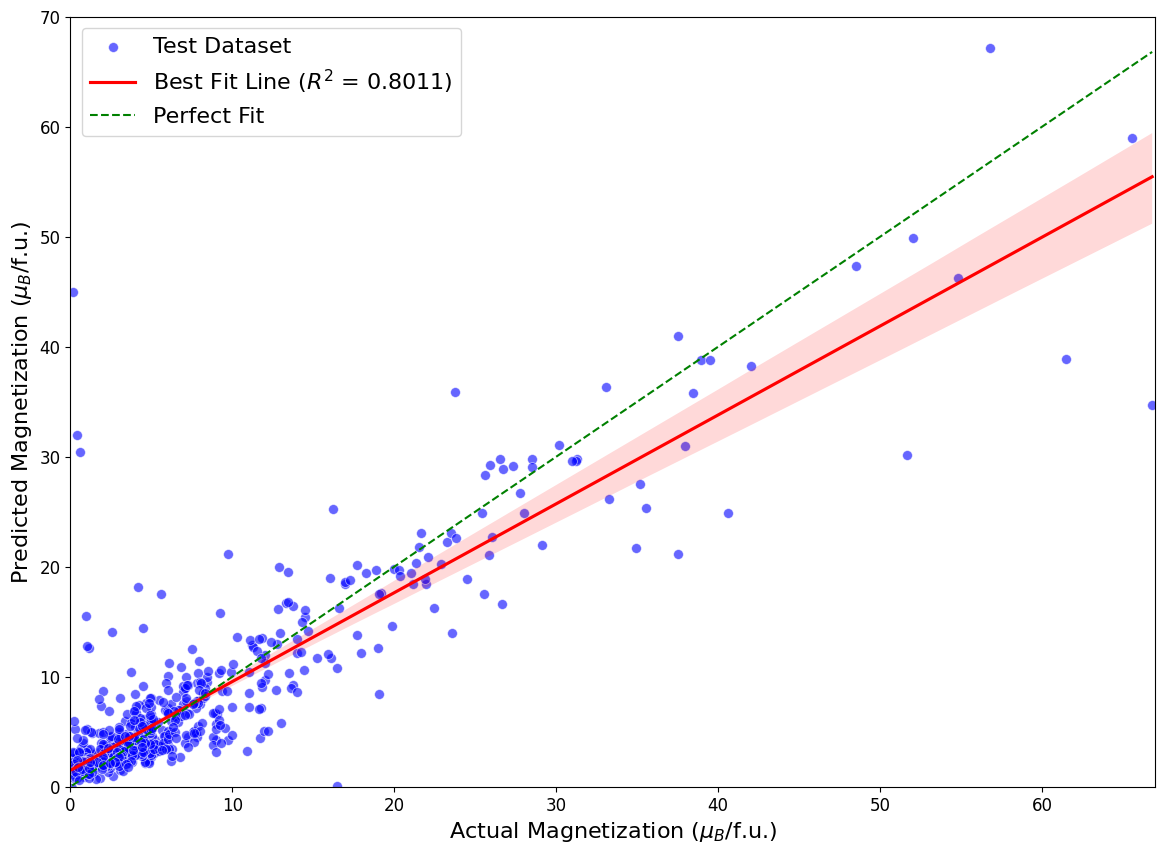

In [18]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_test_flat, y_pred_flat)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_test_flat, y=y_pred_flat, color='blue',
                alpha=0.6, s=50, label='Test Dataset')

sns.regplot(x=y_test_flat, y=y_pred_flat, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.xlim([0, 67])
plt.ylim([0, 70])
plt.legend()
plt.show()

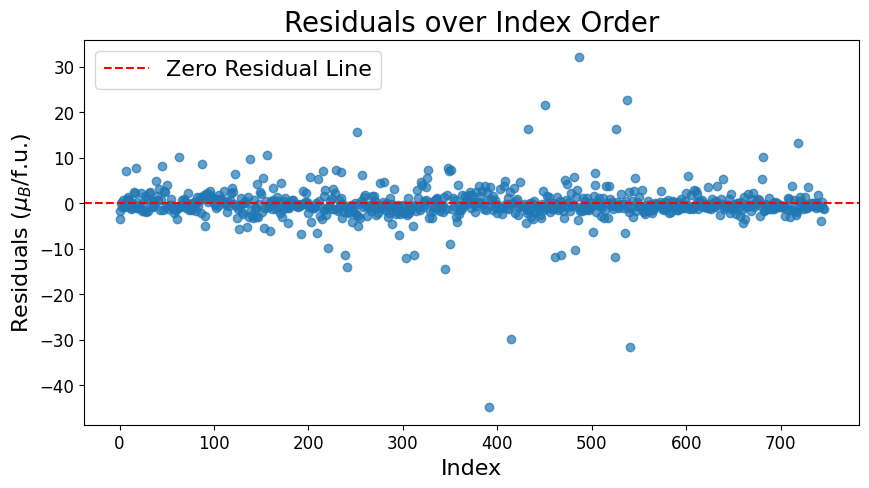

In [19]:
residuals = y_test_flat - y_pred_flat

plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o', linestyle='', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals over Index Order')
plt.xlabel('Index')
plt.ylabel('Residuals ($\u03bc_B$/f.u.)')
plt.legend()
plt.show()

### Reduced Model

In [29]:
def run_pca(X_train, X_test, X_val=None, variance_threshold=0.95, verbose=True):
    pca = PCA()
    pca.fit(X_train)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()

    n_components_optimal = np.argmax(
        explained_variance_ratio >= variance_threshold) + 1
    if verbose:
        print(
            f"Optimal number of components to retain {variance_threshold * 100}% variance: {n_components_optimal}")

    pca_optimal = PCA(n_components=n_components_optimal)
    X_train_reduced = pca_optimal.fit_transform(X_train)
    X_test_reduced = pca_optimal.transform(X_test)
    X_val_reduced = pca_optimal.transform(X_val) if X_val is not None else None

    return X_train_reduced, X_test_reduced, X_val_reduced, n_components_optimal, pca_optimal

In [30]:
X_train_reduced, X_test_reduced, X_val_reduced, n_components, pca_model = run_pca(X_train, X_test, X_val)
print(f"Reduced training set shape: {X_train_reduced.shape}")
print(f"Reduced validation set shape: {X_val_reduced.shape}")
print(f"Reduced test set shape: {X_test_reduced.shape}")

Optimal number of components to retain 95.0% variance: 108
Reduced training set shape: (5197, 108)
Reduced validation set shape: (1504, 108)
Reduced test set shape: (747, 108)


In [31]:
def build_advanced_regression_model(input_shape, dropout_rate=0.5, weight_decay=1e-4):
    inputs = Input(shape=(input_shape,))

    x = Dense(512, activation=None,
              kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    skip1 = Dense(256, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip1 = BatchNormalization()(skip1)
    skip1 = Activation('relu')(skip1)

    x = Dense(256, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Add()([x, skip1])

    x = Dense(128, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    skip2 = Dense(128, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip2 = BatchNormalization()(skip2)
    skip2 = Activation('relu')(skip2)
    x = Add()([x, skip2])

    x = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)

    output = Dense(1, activation='linear')(x)

    model = Model(inputs, output)
    model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss='mean_squared_error',
        metrics=['root_mean_squared_error']
    )

    return model

In [32]:
X_train_reduced.shape

(5197, 108)

In [33]:
input_shape = X_train_reduced.shape[1]

reduced_model = build_advanced_regression_model(input_shape)

reduced_model.summary()

reduced_history = reduced_model.fit(
    X_train_reduced, y_train,
    validation_data=(X_val_reduced, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 108)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │     55,808 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     27,904 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dropout_5[0][0],  │
│                     │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     32,896 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     13,952 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 275,329 (1.05 MB)

 Trainable params: 272,769 (1.04 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 79.2963 - root_mean_squared_error: 8.8250 - val_loss: 31.8139 - val_root_mean_squared_error: 5.6307
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 33.9939 - root_mean_squared_error: 5.8137 - val_loss: 30.7379 - val_root_mean_squared_error: 5.5339
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30.4597 - root_mean_squared_error: 5.5043 - val_loss: 25.7722 - val_root_mean_squared_error: 5.0651
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28.6843 - root_mean_squared_error: 5.3365 - val_loss: 22.2122 - val_root_mean_squared_error: 4.7002
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.7424 - root_mean_squared_error: 4.7498 - val_loss: 22.1817 - val_root_mean_squared_error: 4.6966
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 27.9688 - root_mean_squared_error: 5.2551 - val_loss: 21.4805 - val_root_mean_squared_error: 4.6210
Epoch 7/100
163/163 ━━━━━━━━━━━━━━

In [34]:
test_loss, test_rmse = reduced_model.evaluate(X_test_reduced, y_test)
print(f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 14.2838 - root_mean_squared_error: 3.7152
Test Loss: 15.0567, Test RMSE: 3.8339


In [35]:
y_pred_reduced = reduced_model.predict(X_test_reduced)

r2 = r2_score(y_test, y_pred_reduced)
print(f"R-squared: {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred_reduced))
print(f"Root Mean Squared Error: {rmse:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared: 0.8202
Root Mean Squared Error: 3.8339


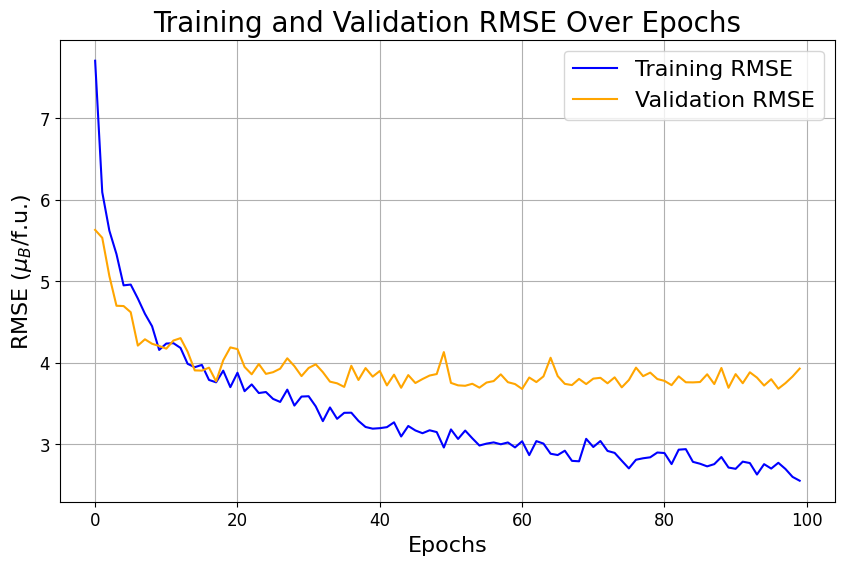

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(reduced_history.history['root_mean_squared_error'],
         label='Training RMSE', color='blue')
plt.plot(reduced_history.history['val_root_mean_squared_error'],
         label='Validation RMSE', color='orange')

plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE ($\u03bc_B$/f.u.)')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
y_test_flat = np.array(y_test).flatten()
y_pred_reduced_flat = np.array(y_pred_reduced).flatten()

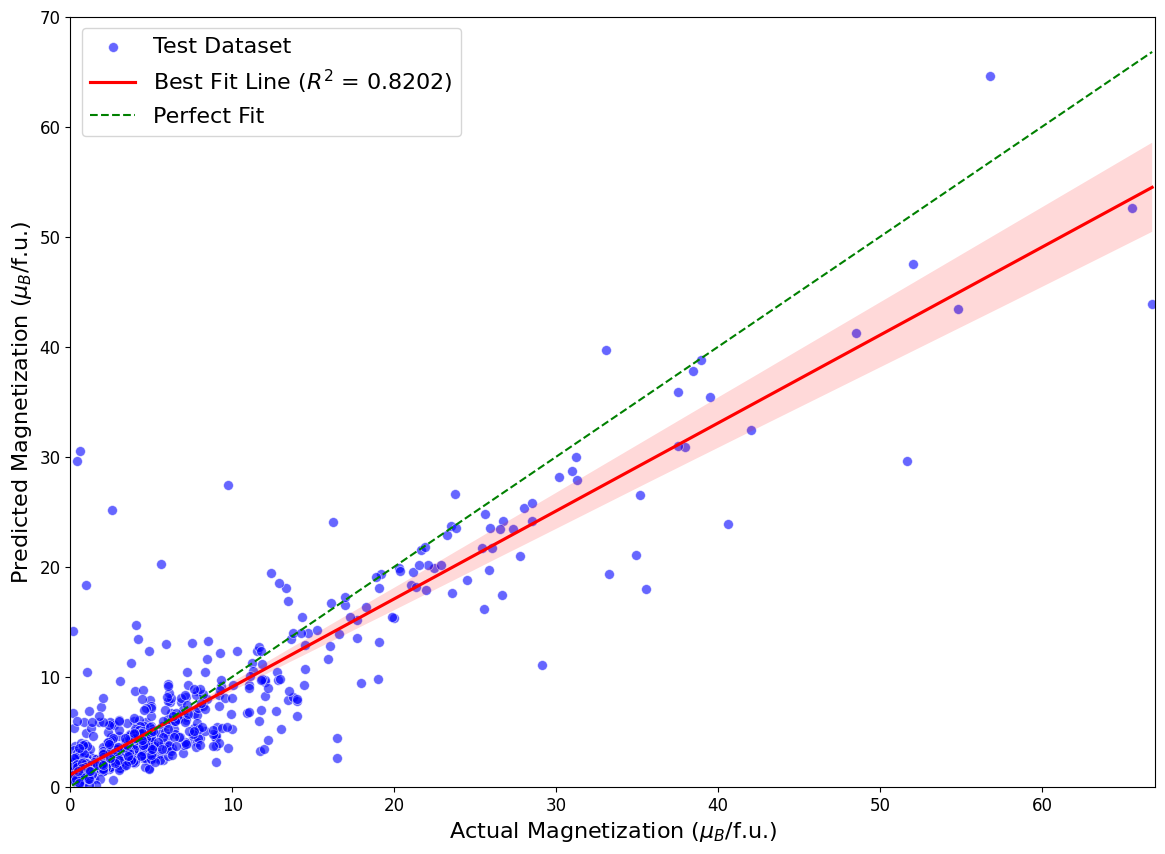

In [38]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_test_flat, y_pred_reduced_flat)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_test_flat, y=y_pred_reduced_flat, color='blue',
                alpha=0.6, s=50, label='Test Dataset')

sns.regplot(x=y_test_flat, y=y_pred_reduced_flat, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.xlim([0, 67])
plt.ylim([0, 70])
plt.legend()
plt.show()

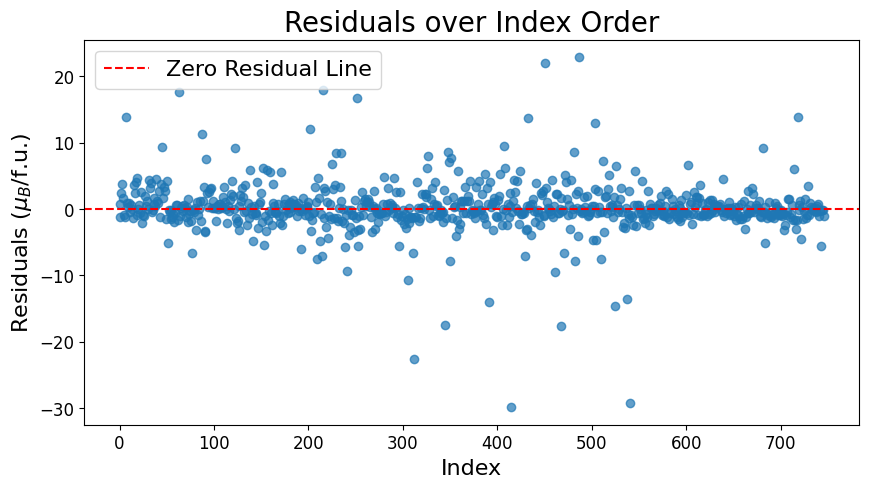

In [39]:
residuals_reduced = y_test_flat - y_pred_reduced_flat

plt.figure(figsize=(10, 5))
plt.plot(residuals_reduced, marker='o', linestyle='', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals over Index Order')
plt.xlabel('Index')
plt.ylabel('Residuals ($\u03bc_B$/f.u.)')
plt.legend()
plt.show()

## Testing On Real Data

In [20]:
df_lit = pd.read_csv(DATA_PATH + "/test/real_data.csv")
df_truth = pd.read_csv(DATA_PATH + "/test/real_results.csv")

In [21]:
df_lit = df_lit.rename(columns=rename_dict)

In [22]:
X_lit_unscaled, y_lit, formulae_pred, skipped_pred = composition.generate_features(
    df_lit, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 19/19 [00:00<00:00, 42502.28it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 19/19 [00:00<00:00, 28319.75it/s]

	Creating Pandas Objects...


In [23]:
X_lit = scaler.transform(X_lit_unscaled)

In [24]:
y_pred = model.predict(X_lit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [25]:
y_pred = np.array(y_pred).flatten()

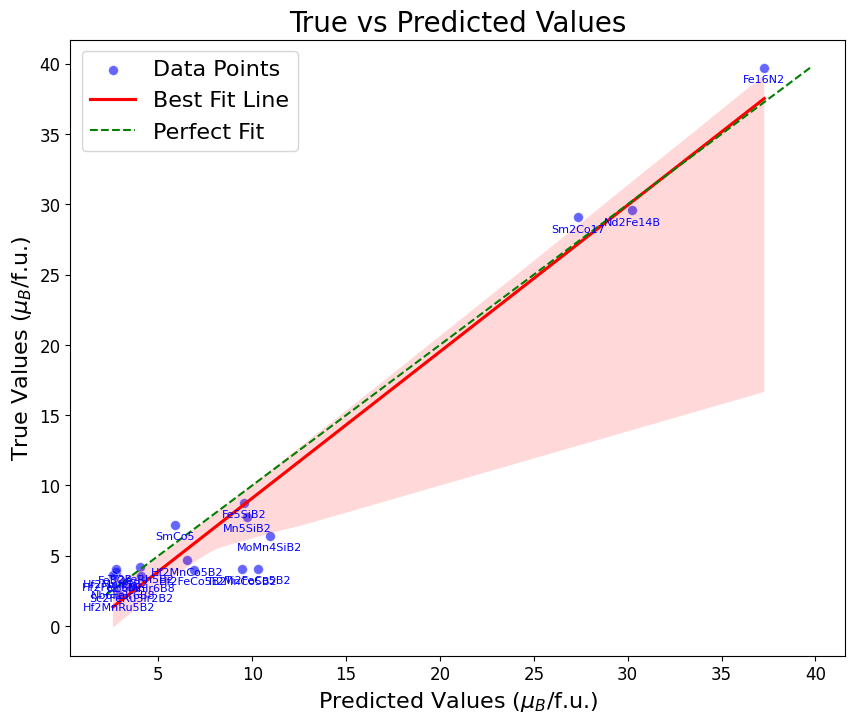

In [26]:
y_true = df_truth.total_magnetization_normalized_formula_units
y_true_formulas = df_truth.formula

plt.figure(figsize=(10, 8))

sns.scatterplot(x=y_pred, y=y_true, color='blue',
                alpha=0.6, s=50, label='Data Points')

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(pred, true - 0.5, formula, fontsize=8,
             ha='center', va='top', color='blue')

sns.regplot(x=y_pred, y=y_true, scatter=False,
            color='red', label='Best Fit Line')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.title('True vs Predicted Values')
plt.xlabel('Predicted Values ($\u03bc_B$/f.u.)')
plt.ylabel('True Values ($\u03bc_B$/f.u.)')
plt.legend()

plt.show()

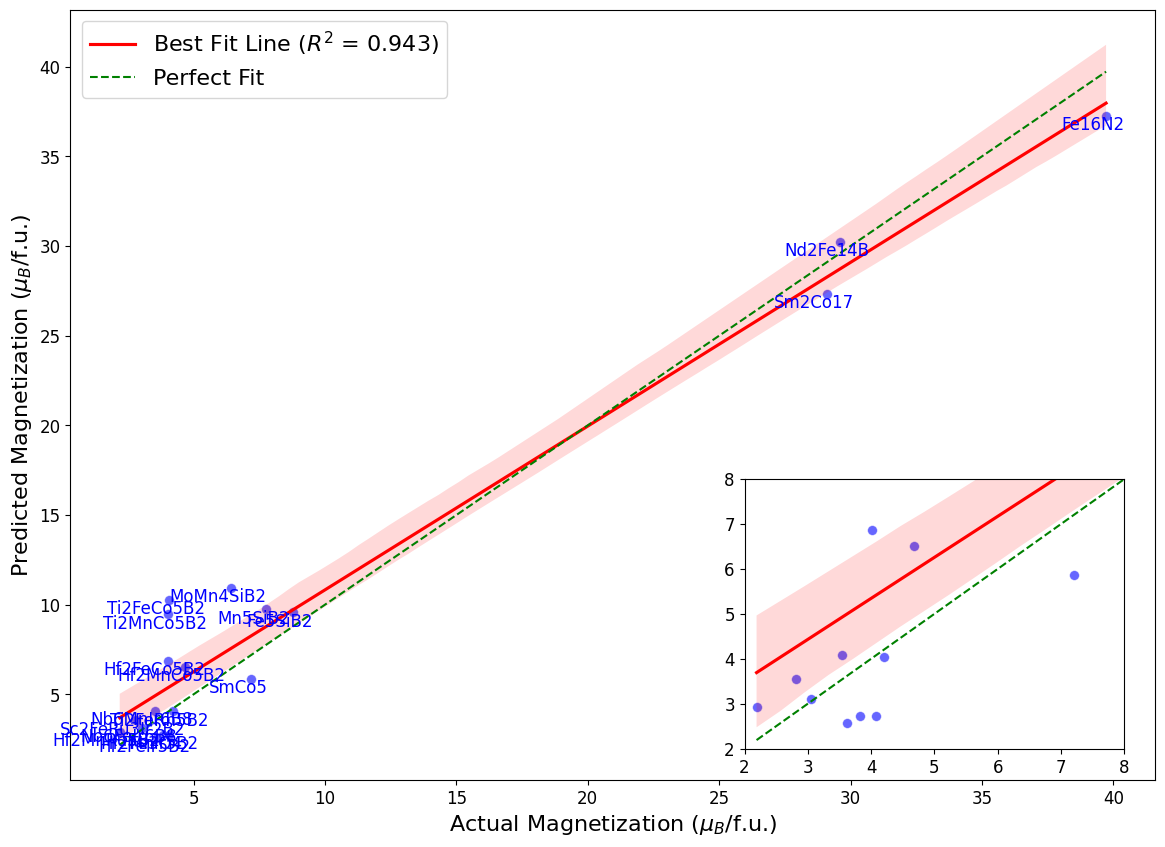

In [27]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_true, y_pred)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_true, y=y_pred, color='blue',
                alpha=0.6, s=50)

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(true - 0.5, pred, formula, fontsize=12,
             ha='center', va='top', color='blue')

sns.regplot(x=y_true, y=y_pred, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.legend()

inset_ax = inset_axes(plt.gca(), width="35%", height="35%",
                      loc='lower right', borderpad=1.4)

x_min, x_max = min(y_pred) - 0.1, max(y_pred) * 0.2
y_min, y_max = min(y_true) - 0.1, max(y_true) * 0.2

sns.scatterplot(x=y_true, y=y_pred, color='blue', alpha=0.6, s=50, ax=inset_ax)

sns.regplot(x=y_true, y=y_pred, scatter=False, color='red', ax=inset_ax)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

inset_ax.set_ylim(2, 8)
inset_ax.set_xlim(2, 8)
inset_ax.set_xlabel(" ")

plt.show()

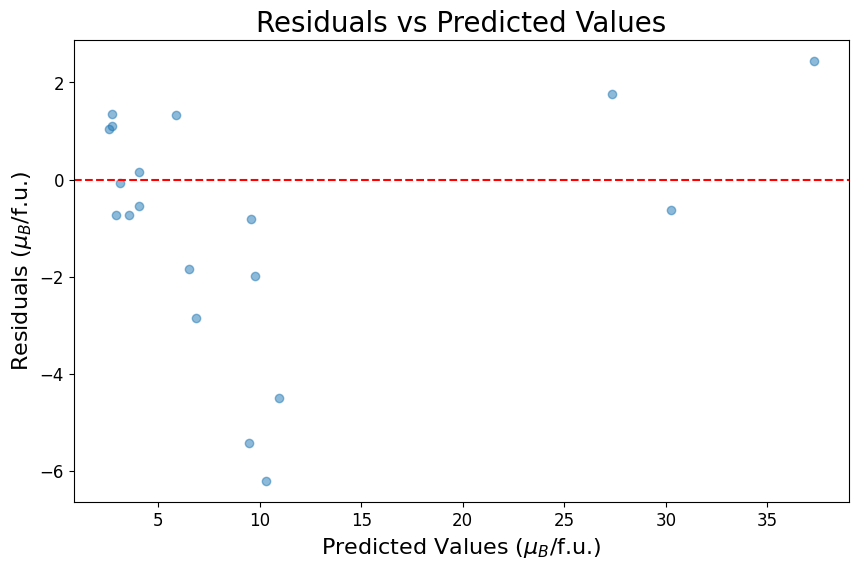

In [28]:
# Calculate residuals
residuals_reg = y_true - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_reg, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values ($\u03bc_B$/f.u.)')
plt.ylabel('Residuals ($\u03bc_B$/f.u.)')
plt.title('Residuals vs Predicted Values')
plt.show()